In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cvxpy as cp
from pypfopt import EfficientFrontier
from pypfopt import EfficientCVaR
from pypfopt.plotting import plot_efficient_frontier
import seaborn as sns


In [2]:
def variance(w, cov):
    return np.dot(w.T, np.dot(cov,w))

def returns(w, exp):
    return np.dot(w.T, exp)

# Process Data

In [3]:
DATA_PATH = '/home/lescudero/Documentos/GitHub/data'
PRICES_PATH = os.path.join(DATA_PATH, 'prices')
SIMULATION_DATA_PATH = os.path.join(DATA_PATH, 'simulation data')
prices = pd.read_csv(os.path.join(PRICES_PATH, 'Spain_prices.csv'))

In [4]:
prices['price'] = prices['Price (EUR/MWhe)']
prices['time'] = pd.to_datetime(prices['Datetime (UTC)'])
prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time
0,Spain,ESP,2015-01-01 00:00:00,2015-01-01 01:00:00,48.10,48.10,2015-01-01 00:00:00
1,Spain,ESP,2015-01-01 01:00:00,2015-01-01 02:00:00,47.33,47.33,2015-01-01 01:00:00
2,Spain,ESP,2015-01-01 02:00:00,2015-01-01 03:00:00,42.27,42.27,2015-01-01 02:00:00
3,Spain,ESP,2015-01-01 03:00:00,2015-01-01 04:00:00,38.41,38.41,2015-01-01 03:00:00
4,Spain,ESP,2015-01-01 04:00:00,2015-01-01 05:00:00,35.72,35.72,2015-01-01 04:00:00


In [5]:
df_list = []
for file_name in os.listdir(SIMULATION_DATA_PATH):
    df = pd.read_csv(os.path.join(SIMULATION_DATA_PATH, file_name),sep = ',', comment = '#')
    file_name_split = file_name.split('_')
    df['lat_lon'] = file_name_split[2]+ '_' + file_name_split[3]
    df_list.append(df)
production = pd.concat(df_list)

In [6]:
production['time'] = pd.to_datetime(production['time'])
production.head()

,time,local_time,electricity,lat_lon
0,2019-01-01 00:00:00,2019-01-01 01:00,0.110,39.3969_-6.5483
1,2019-01-01 01:00:00,2019-01-01 02:00,0.110,39.3969_-6.5483
2,2019-01-01 02:00:00,2019-01-01 03:00,0.106,39.3969_-6.5483
3,2019-01-01 03:00:00,2019-01-01 04:00,0.086,39.3969_-6.5483
4,2019-01-01 04:00:00,2019-01-01 05:00,0.063,39.3969_-6.5483


In [7]:
production['hour'] = production['time'].dt.hour
production['day'] = production['time'].dt.day
production['month'] = production['time'].dt.month
production['year'] = production['time'].dt.year

prices['hour'] = prices['time'].dt.hour
prices['day'] = prices['time'].dt.day
prices['month'] = prices['time'].dt.month
prices['year'] = prices['time'].dt.year

In [8]:
# Filter desired dates
final_time_price = prices['time'].max() 
start_time_price = final_time_price - pd.Timedelta(days=365)

mask_dates = (prices['time'] <= final_time_price) & (prices['time'] > start_time_price)
last_y_prices = prices[mask_dates]
last_y_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time,hour,day,month,year
83469,Spain,ESP,2024-07-09 21:00:00,2024-07-09 23:00:00,116.38,116.38,2024-07-09 21:00:00,21,9,7,2024
83470,Spain,ESP,2024-07-09 22:00:00,2024-07-10 00:00:00,107.94,107.94,2024-07-09 22:00:00,22,9,7,2024
83471,Spain,ESP,2024-07-09 23:00:00,2024-07-10 01:00:00,106.81,106.81,2024-07-09 23:00:00,23,9,7,2024
83472,Spain,ESP,2024-07-10 00:00:00,2024-07-10 02:00:00,104.22,104.22,2024-07-10 00:00:00,0,10,7,2024
83473,Spain,ESP,2024-07-10 01:00:00,2024-07-10 03:00:00,102.61,102.61,2024-07-10 01:00:00,1,10,7,2024


In [9]:
production.head()

,time,local_time,electricity,lat_lon,hour,day,month,year
0,2019-01-01 00:00:00,2019-01-01 01:00,0.110,39.3969_-6.5483,0,1,1,2019
1,2019-01-01 01:00:00,2019-01-01 02:00,0.110,39.3969_-6.5483,1,1,1,2019
2,2019-01-01 02:00:00,2019-01-01 03:00,0.106,39.3969_-6.5483,2,1,1,2019
3,2019-01-01 03:00:00,2019-01-01 04:00,0.086,39.3969_-6.5483,3,1,1,2019
4,2019-01-01 04:00:00,2019-01-01 05:00,0.063,39.3969_-6.5483,4,1,1,2019


In [10]:
# Merge in same day but different year and compute revenue
df_revenue = pd.merge(production, last_y_prices, on=['hour','day','month'], how='inner')
df_revenue = df_revenue[['lat_lon','price','electricity','hour','day','month']]
df_revenue['revenue'] = df_revenue['price'] * df_revenue['electricity'] *2 # (price is in EUR/MWh and electricity is in kWh)

In [11]:
# Add fictitious year and time stamp so we have a time series
df_revenue['year'] = 2019
df_revenue['time_stamp'] = df_revenue[['year', 'month', 'day', 'hour']].apply(lambda s : datetime.datetime(*s),axis = 1)

## Start model

In [12]:
monthly_rev = pd.pivot_table(df_revenue, values='revenue', index='time_stamp', columns='lat_lon', aggfunc='sum')
monthly_rev

lat_lon,36.2516_-5.6719,36.4470_-5.9067,36.5728_-5.9615,37.2983_-1.8924,37.3170_-7.3387,37.3419_-1.7672,37.3467_-5.6815,37.4351_-5.3276,37.4600_-3.2775,37.5021_-4.4298,...,42.1524_2.9923,42.2329_-6.7792,42.2445_-5.1985,42.4587_-8.3965,42.5911_-8.4577,42.7752_-7.9490,42.9692_-1.9821,43.0159_-7.0531,43.0932_-4.2335,43.1742_-6.5667
time_stamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,154.74984,146.06490,135.27452,13.94854,91.58664,14.47490,66.05818,52.10964,17.36988,39.74018,...,180.80466,109.48288,138.69586,43.42470,42.63516,115.53602,16.31716,140.80130,2.10544,102.64020
2019-01-01 01:00:00,149.63562,141.22026,132.01596,14.20092,90.20214,14.20092,68.11182,53.12196,16.83072,39.44700,...,183.29706,111.76650,136.48662,43.91766,44.44362,122.02272,21.03840,146.74284,1.31490,98.09154
2019-01-01 02:00:00,139.83088,131.68284,124.32332,14.45620,86.47436,14.19336,68.60124,51.51664,14.45620,35.74624,...,181.35960,108.55292,131.68284,42.05440,44.15712,117.48948,27.07252,149.29312,2.10272,92.78252
2019-01-01 03:00:00,116.87530,109.16394,104.10336,15.18174,75.66772,14.45880,59.76304,40.24366,8.91626,24.33898,...,159.76974,95.18710,112.29668,33.49622,36.62896,95.18710,28.19466,134.22586,3.13274,77.83654
2019-01-01 04:00:00,102.41760,94.55660,91.63680,16.39580,70.52440,15.49740,54.57780,32.34240,4.49200,15.04820,...,142.84560,84.89880,98.37480,26.27820,29.42260,75.69020,25.15520,118.81340,4.49200,63.11260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,215.41800,200.43240,177.01740,3.43420,10.30260,2.80980,45.26900,44.95680,2.80980,15.61000,...,9.05380,5.93180,12.80020,79.29880,83.35740,49.63980,4.68300,26.84920,0.93660,7.80500
2019-12-31 20:00:00,211.79340,197.01010,174.98600,3.01700,11.76630,2.41360,48.57370,48.27200,3.62040,19.91220,...,11.16290,7.84420,13.57650,74.82160,71.50290,39.22100,2.11190,23.83430,1.20680,11.16290
2019-12-31 21:00:00,203.02640,188.58640,167.50400,3.17680,14.44000,2.88800,48.22960,48.22960,5.19840,25.41440,...,12.99600,10.68560,10.39680,67.29040,60.35920,31.19040,1.15520,22.81520,4.62080,17.03920


In [13]:
cov = monthly_rev.cov() * monthly_rev.shape[0] 
exp = monthly_rev.mean() * monthly_rev.shape[0]  # mean() ¿ 
#monthly_rev.sum()
# Hourly correlation is still very big although some points close to 0.5 
monthly_rev.corr()

lat_lon,36.2516_-5.6719,36.4470_-5.9067,36.5728_-5.9615,37.2983_-1.8924,37.3170_-7.3387,37.3419_-1.7672,37.3467_-5.6815,37.4351_-5.3276,37.4600_-3.2775,37.5021_-4.4298,...,42.1524_2.9923,42.2329_-6.7792,42.2445_-5.1985,42.4587_-8.3965,42.5911_-8.4577,42.7752_-7.9490,42.9692_-1.9821,43.0159_-7.0531,43.0932_-4.2335,43.1742_-6.5667
lat_lon,,,,,,,,,,,,,,,,,,,,,
36.2516_-5.6719,1.000000,0.986218,0.971015,0.564366,0.681304,0.556353,0.725786,0.698086,0.641057,0.644926,...,0.351805,0.538812,0.512992,0.498637,0.495578,0.518506,0.514808,0.493223,0.490598,0.499642
36.4470_-5.9067,0.986218,1.000000,0.995958,0.588019,0.730633,0.580267,0.773842,0.742438,0.668806,0.680512,...,0.368398,0.560772,0.539497,0.514149,0.510654,0.532955,0.551305,0.508263,0.529991,0.521239
36.5728_-5.9615,0.971015,0.995958,1.000000,0.603068,0.763139,0.595347,0.814301,0.781735,0.692029,0.714933,...,0.381868,0.580256,0.560840,0.530319,0.526237,0.548723,0.571382,0.524335,0.552298,0.538128
37.2983_-1.8924,0.564366,0.588019,0.603068,1.000000,0.635124,0.998703,0.659026,0.658710,0.781557,0.672022,...,0.533399,0.612316,0.603946,0.514113,0.513574,0.516956,0.574880,0.517456,0.597735,0.573214
37.3170_-7.3387,0.681304,0.730633,0.763139,0.635124,1.000000,0.630342,0.863810,0.844835,0.685067,0.768697,...,0.490765,0.653946,0.667381,0.576152,0.572887,0.579853,0.614836,0.551382,0.625246,0.575935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42.7752_-7.9490,0.518506,0.532955,0.548723,0.516956,0.579853,0.515034,0.603659,0.597468,0.554468,0.567782,...,0.417258,0.865032,0.802537,0.980135,0.980183,1.000000,0.628878,0.967548,0.767935,0.923262
42.9692_-1.9821,0.514808,0.551305,0.571382,0.574880,0.614836,0.576276,0.607766,0.603165,0.595761,0.586779,...,0.457176,0.680842,0.703262,0.619513,0.617526,0.628878,1.000000,0.630300,0.834739,0.676327
43.0159_-7.0531,0.493223,0.508263,0.524335,0.517456,0.551382,0.515620,0.578471,0.569666,0.551528,0.544858,...,0.402725,0.861908,0.786795,0.932318,0.932001,0.967548,0.630300,1.000000,0.785126,0.968521


In [14]:
# Compute 3 special points (min var, max sharpe, max returns)

ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
min_volatility_w = pd.Series((ef.min_volatility())) # ef.clean_weights()

ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
max_sharpe_w = pd.Series((ef.max_sharpe()))

max_returns_location = monthly_rev.sum().idxmax()
max_returns_w = {location: float(0) for location in max_sharpe_w.index}
max_returns_w[max_returns_location] = 1.0
max_returns_w = pd.Series(max_returns_w)

extremes_w = [min_volatility_w, max_sharpe_w, max_returns_w]
extremes_var = [variance(w, cov) for w in extremes_w]
extremes_exp = [returns(w, exp) for w in extremes_w]

In [15]:
# Compute points in boundary

boundary_range_exp = np.linspace(min(extremes_exp)+0.001, max(extremes_exp)-0.001, 100)
boundary_w = []

for boundary_exp in boundary_range_exp:
    ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
    w = pd.Series(ef.efficient_return(boundary_exp))
    boundary_w.append(w)

boundary_var = [variance(w, cov) for w in boundary_w]
boundary_exp = [returns(w, exp) for w in boundary_w]

In [16]:
#Parameters
BETA=0.96
 
ef_cvar = EfficientCVaR(exp, monthly_rev, beta=BETA, weight_bounds=(0, 1))
weights = ef_cvar.min_cvar()
cleaned_weights = ef_cvar.clean_weights()
print("Weights (min CVaR):\n", pd.Series(cleaned_weights))
print("\nUsing min CVaR the portfolio performance is:\n")
ef_cvar.portfolio_performance(verbose=True)

Weights (min CVaR):
 36.2516_-5.6719    0.0
36.4470_-5.9067    0.0
36.5728_-5.9615    0.0
37.2983_-1.8924    0.0
37.3170_-7.3387    0.0
                  ... 
42.7752_-7.9490    0.0
42.9692_-1.9821    0.0
43.0159_-7.0531    0.0
43.0932_-4.2335    0.0
43.1742_-6.5667    0.0
Length: 64, dtype: float64

Using min CVaR the portfolio performance is:

Expected annual return: 25574788.0%
Conditional Value at Risk: 135.14%


(255747.8798206669, 1.351424140681002)

In [17]:
ef_cvar = EfficientCVaR(exp, monthly_rev, beta=BETA, weight_bounds=(0, 1))
target_cvar = 0.1 # EUR/hour (PPA revenue)
weights = ef_cvar.efficient_risk(target_cvar)
cleaned_weights = ef_cvar.clean_weights()
print(f"Weights (return-max for CVaR ≤ {target_cvar}):\n", pd.Series(cleaned_weights))
print(f"\nUsing return-max for CVaR ≤ {target_cvar} the portfolio performance is:\n")
ef_cvar.portfolio_performance(verbose=True)
 

OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')

In [18]:
ef_cvar = EfficientCVaR(exp, monthly_rev, beta=BETA, weight_bounds=(0, 1))
target_return = 0 # EUR/hour (but only 0 works....)
weights = ef_cvar.efficient_return(target_return)
cleaned_weights = ef_cvar.clean_weights()
print(f"Weights min CVaR for {target_return}:\n", pd.Series(cleaned_weights))
print(f"\nUsing (min CVaR for {target_return} the portfolio performance is:\n")
ef_cvar.portfolio_performance(verbose=True)

Weights min CVaR for 0:
 36.2516_-5.6719    0.0
36.4470_-5.9067    0.0
36.5728_-5.9615    0.0
37.2983_-1.8924    0.0
37.3170_-7.3387    0.0
                  ... 
42.7752_-7.9490    0.0
42.9692_-1.9821    0.0
43.0159_-7.0531    0.0
43.0932_-4.2335    0.0
43.1742_-6.5667    0.0
Length: 64, dtype: float64

Using (min CVaR for 0 the portfolio performance is:

Expected annual return: 25574788.0%
Conditional Value at Risk: 135.14%


(255747.87982044977, 1.3514241404957026)

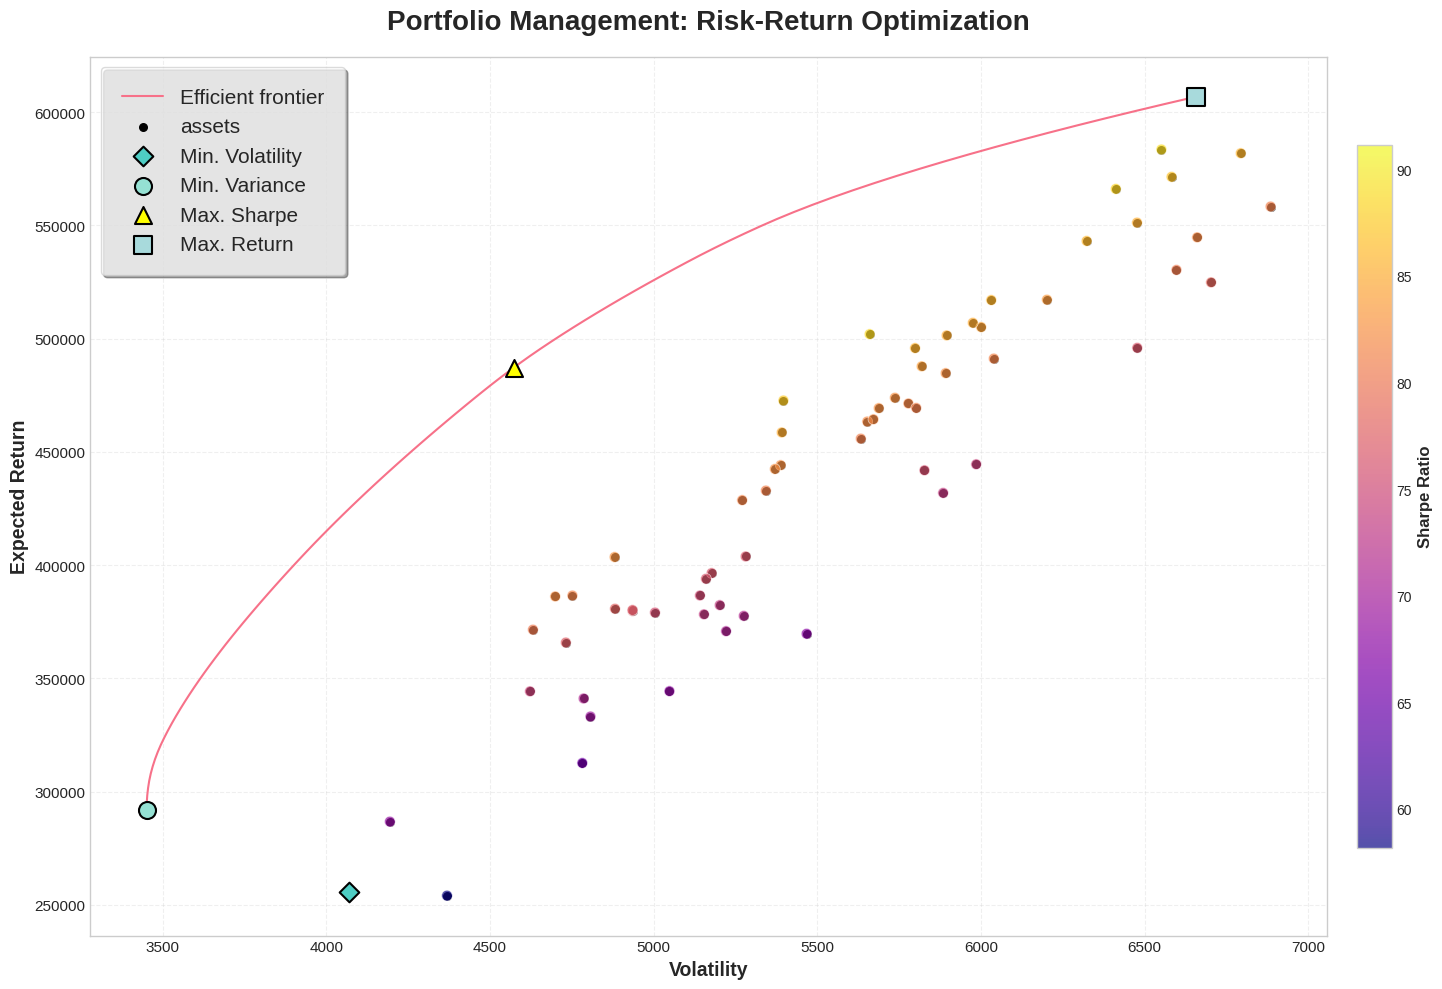

In [23]:

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

n = monthly_rev.shape[1]
w = []
for i in range(n):
    e = [0]*n
    e[i] = 1
    w.append(e)

df_w = pd.DataFrame(w, columns=monthly_rev.columns)
df_plot = pd.DataFrame(data=[], index=df_w.index)
df_plot['cov'] = df_w.apply(variance, axis=1, cov=cov)
df_plot['exp'] = df_w.apply(returns, axis=1, exp=exp)
df_plot['Volatility'] = np.sqrt(df_plot['cov'])
df_plot['Ratio de Sharpe'] = df_plot['exp'] / df_plot['Volatility']


max_sharpe_idx = df_plot["Ratio de Sharpe"].idxmax()
max_sharpe_port = df_plot.iloc[max_sharpe_idx]
min_vol_idx = df_plot["Volatility"].idxmin()
min_vol_port = df_plot.iloc[min_vol_idx]


fig, ax = plt.subplots(figsize=(16, 10))
fig.patch.set_facecolor('white')


ef = EfficientFrontier(exp, cov, weight_bounds=(0, 1))
plot_efficient_frontier(ef, ax=ax, show_assets=True)

scatter = ax.scatter(df_plot["Volatility"], df_plot["exp"], 
                    c=df_plot["Ratio de Sharpe"], 
                    cmap="plasma", 
                    s=60, 
                    alpha=0.7,
                    edgecolors='white',
                    linewidth=0.5)


cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Sharpe Ratio", fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)


ax.scatter(min_vol_port["Volatility"], min_vol_port["exp"], 
          c="#4ECDC4", marker="D", s=100, 
          label="Min. Volatility", edgecolors='black', linewidth=1.5, zorder=5)

ax.scatter(np.sqrt(extremes_var[0]), extremes_exp[0], 
          c="#95E1D3", marker="o", s=150, 
          label="Min. Variance", edgecolors='black', linewidth=1.5, zorder=5)

ax.scatter(np.sqrt(extremes_var[1]), extremes_exp[1], 
          c="yellow", marker="^", s=150, 
          label="Max. Sharpe", edgecolors='black', linewidth=1.5, zorder=5)

ax.scatter(np.sqrt(extremes_var[2]), extremes_exp[2], 
          c="#A8DADC", marker="s", s=150, 
          label="Max. Return", edgecolors='black', linewidth=1.5, zorder=5)

ax.set_xlabel("Volatility", fontsize=14, fontweight='bold')
ax.set_ylabel("Expected Return", fontsize=14, fontweight='bold')
ax.set_title("Portfolio Management: Risk-Return Optimization", 
            fontsize=20, fontweight='bold', pad=20)


ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(True, alpha=0.3, linestyle='--')


legend = ax.legend(loc='upper left', fontsize=15, frameon=True, 
                  shadow=True, fancybox=True, borderpad=1)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.7)

plt.tight_layout()
plt.show()



In [21]:

print("Pesos del portafolio con el mejor Ratio de Sharpe:")
print(df_w.iloc[max_sharpe_idx])
print("\nPortafolio con el mejor Ratio de Sharpe:")
print(f"Rendimiento Esperado: {max_sharpe_port['exp']*100:.2f}%")
print(f"Volatilidad: {max_sharpe_port['Volatility']*100:.2f}%")
print(f"Ratio de Sharpe: {max_sharpe_port['Ratio de Sharpe']:.2f}")

print("\nPesos del portafolio con la mínima Volatilidad:")
print(df_w.iloc[min_vol_idx])
print("\nPortafolio con la mínima Volatilidad:")
print(f"Rendimiento Esperado: {min_vol_port['exp']*100:.2f}%")
print(f"Volatilidad: {min_vol_port['Volatility']*100:.2f}%")
print(f"Ratio de Sharpe: {min_vol_port['Ratio de Sharpe']:.2f}")

Pesos del portafolio con el mejor Ratio de Sharpe:
lat_lon
36.2516_-5.6719    0
36.4470_-5.9067    0
36.5728_-5.9615    0
37.2983_-1.8924    0
37.3170_-7.3387    0
                  ..
42.7752_-7.9490    0
42.9692_-1.9821    0
43.0159_-7.0531    0
43.0932_-4.2335    0
43.1742_-6.5667    0
Name: 40, Length: 64, dtype: int64

Portafolio con el mejor Ratio de Sharpe:
Rendimiento Esperado: 60685647.03%
Volatilidad: 665707.29%
Ratio de Sharpe: 91.16

Pesos del portafolio con la mínima Volatilidad:
lat_lon
36.2516_-5.6719    0
36.4470_-5.9067    0
36.5728_-5.9615    0
37.2983_-1.8924    0
37.3170_-7.3387    0
                  ..
42.7752_-7.9490    0
42.9692_-1.9821    0
43.0159_-7.0531    0
43.0932_-4.2335    0
43.1742_-6.5667    0
Name: 53, Length: 64, dtype: int64

Portafolio con la mínima Volatilidad:
Rendimiento Esperado: 25574787.98%
Volatilidad: 407022.17%
Ratio de Sharpe: 62.83


In [19]:
# TODO:
# - Get 3 special points
# - Get curve
# - Plot solutions on map nicely. 
# - 
# - compare minimum vairiance/sharpe with what one would get in specific location. How much improvement
# - Look correlations and see if we can get good result with fewer assets than boundary?
# 
#  utilitzar els 10 anys de preus? Fer model treient dades de vent reals i produccio?

In [20]:
#TODO: mirar si algunes estacions mai utilitzades en corva. 